In [113]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import missingno as msno
from sklearn.compose import ColumnTransformer
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns


In [114]:
# !pip install missingno

### Data Exploration

In [115]:
df = pd.read_csv("houses.csv").reindex()
df.head()

index                                              title  final_price  \
0      0  1303 - 38 Grenville St, Toronto (C4461599) | Z...       855000   
1      1          2 Cabot Crt, Toronto (W4502992) | Zoocasa       885000   
2      2  1504 - 30 Roehampton Ave, Toronto (C4511330) |...       550000   
3      3  514 - 65 East Liberty St, Toronto (C4515763) |...       665000   
4      4        61 Twelfth St, Toronto (W4519375) | Zoocasa       825513   

   list_price    bedrooms  bathrooms   sqft  parking  \
0      870000  2 + 1 beds          2  850.0        1   
1      898000      3 beds          2    NaN        6   
2      549900      1 beds          1  550.0        0   
3      600000  1 + 1 beds          1  650.0        1   
4      839000      2 beds          2    NaN        1   

                                         description       mls           type  \
0  Luxurious And Spacious Murano Tower. 2+1, 2 Ba...  C4461599      Condo Apt   
1  Fantastic Opportunity To Live Within The Histo...  W4502992  Semi-Detached   
2  Bright Sunfilled Spacious 1 Bdr Unit; Floor To...  C4511330      Condo Apt   
3  Rare Loft-Like Condo In Liberty Village W/ 18'...  C4515763      Condo Apt   
4  Location! Location! Location. Your Cottage In ...  W4519375       Detached   

                                           full_link  \
0  https://www.zoocasa.com/toronto-on-real-estate...   
1  https://www.zoocasa.com/toronto-on-real-estate...   
2  https://www.zoocasa.com/toronto-on-real-estate...   
3  https://www.zoocasa.com/toronto-on-real-estate...   
4  https://www.zoocasa.com/toronto-on-real-estate...   

                                     full_address        lat       long  \
0      38 Grenville St, Toronto , Ontario, Canada  43.661896 -79.385748   
1          2 Cabot Crt, Toronto , Ontario, Canada  43.646982 -79.530356   
2    30 Roehampton Ave, Toronto , Ontario, Canada  43.708472 -79.397498   
3   65 East Liberty St, Toronto , Ontario, Canada  43.638399 -79.414448   
4        61 Twelfth St, Toronto , Ontario, Canada  43.597096 -79.509612   

                city_district  mean_district_income  district_code  
0         Bay Street Corridor                 56526             76  
1  Islington-City Centre West                 52787             14  
2         Mount Pleasant West                 57039            104  
3                     Niagara                 70623             82  
4                 New Toronto                 44101             18

In [116]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15234 entries, 0 to 15233
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 15234 non-null  int64  
 1   title                 15234 non-null  object 
 2   final_price           15234 non-null  int64  
 3   list_price            15234 non-null  int64  
 4   bedrooms              15234 non-null  object 
 5   bathrooms             15234 non-null  int64  
 6   sqft                  10713 non-null  float64
 7   parking               15234 non-null  int64  
 8   description           15185 non-null  object 
 9   mls                   15234 non-null  object 
 10  type                  15234 non-null  object 
 11  full_link             15234 non-null  object 
 12  full_address          15234 non-null  object 
 13  lat                   15234 non-null  float64
 14  long                  15234 non-null  float64
 15  city_district      

Index(['index', 'title', 'final_price', 'list_price', 'bedrooms', 'bathrooms',
       'sqft', 'parking', 'description', 'mls', 'type', 'full_link',
       'full_address', 'lat', 'long', 'city_district', 'mean_district_income',
       'district_code'],
      dtype='object')

In [117]:
df.bedrooms

0        2 + 1 beds
1            3 beds
2            1 beds
3        1 + 1 beds
4            2 beds
            ...    
15229        2 beds
15230        5 beds
15231        3 beds
15232        1 beds
15233    2 + 1 beds
Name: bedrooms, Length: 15234, dtype: object

In [118]:
df.drop(['title', 'list_price', 'mls'], axis=1, inplace=True)

### Pre-Processing for Baseline Model

In [119]:
df['bedrooms'] = df['bedrooms'].str.replace(' beds', '')
df['bedrooms'] = df['bedrooms'].str.replace(' +', '')

C:\Users\bevli\AppData\Local\Temp/ipykernel_2836/1930054018.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['bedrooms'] = df['bedrooms'].str.replace(' +', '')


In [120]:
#Splitting bedrooms into bedroom plus den if item contains '+'
bedroom_den = df['bedrooms'].tolist()

bedroom = []
den = [] 

for i in bedroom_den:
    if '+' in i:
        x = i.split('+')
        bedroom.append(x[0])
        den.append(x[1])
    else:
        bedroom.append(i)
        den.append(0)
        

In [121]:
print (len(bedroom), len(den))

15234 15234


In [122]:
#Adding bedroom and den columns to DataFrame

df_1 = pd.concat([pd.Series(bedroom,name='bedroom'),pd.Series(den,name='den')], axis=1).reindex()

# Merge two Dataframes on index of both the dataframes
df = df.merge(df_1, left_index = True, right_index=True)
df.drop(columns = ['bedrooms'], inplace = True, axis = 1)

In [123]:
#Converting bedroom and den object type to int

df[['bedroom','den']] = df[['bedroom','den']].astype('int64')

In [124]:
df.drop('index',inplace = True,axis =1)

### Modeling to Predict missing Square Footage values

In [125]:
df_repl = df.copy(deep = True)

In [126]:
df_repl.drop(['description','full_link','full_address', 'lat', 'long','district_code', 'mean_district_income' ],axis = 1, inplace = True)

final_price       0.000000
bathrooms         0.000000
sqft             29.677038
parking           0.000000
type              0.000000
city_district     0.000000
bedroom           0.000000
den               0.000000
dtype: float64


<AxesSubplot:>

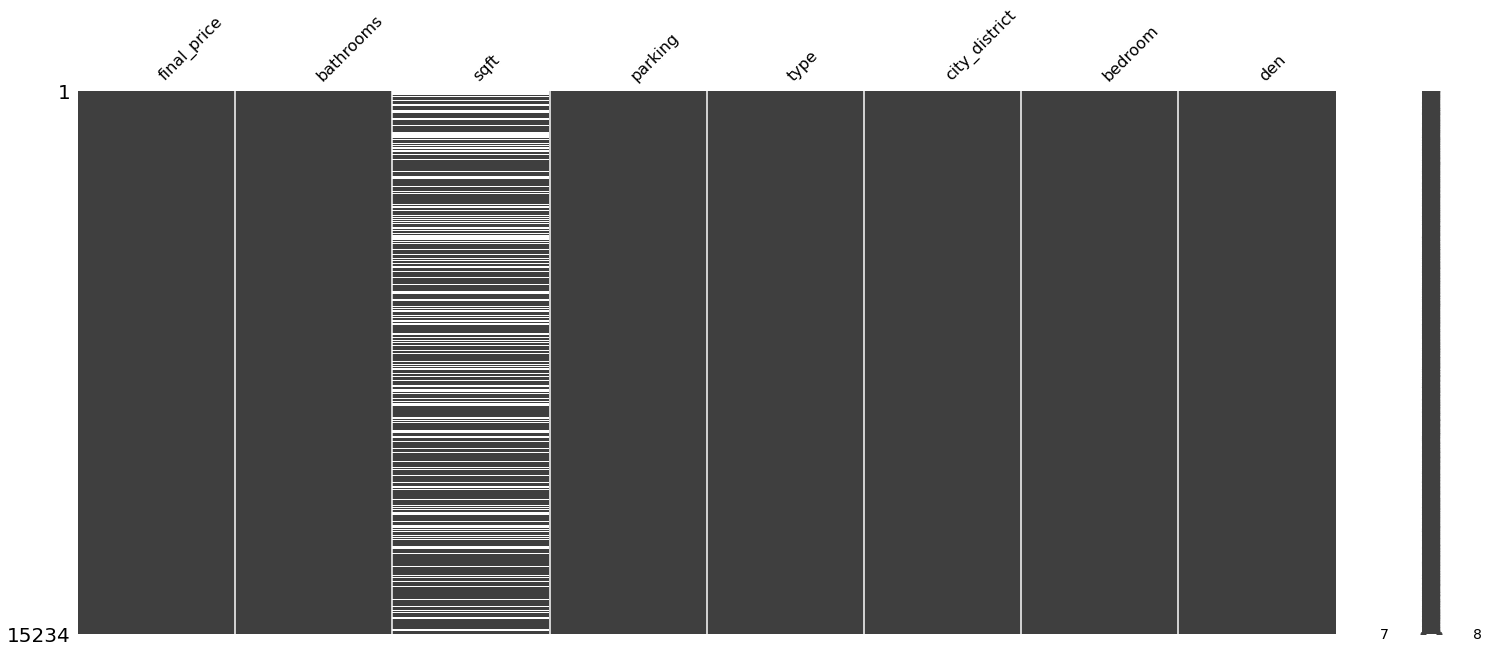

In [127]:
mis_value_percent = 100 * df_repl.isnull().sum() / len(df_repl)
print(mis_value_percent)

msno.matrix(df_repl)

Condo Apt  -  7572
Number of null values -  0


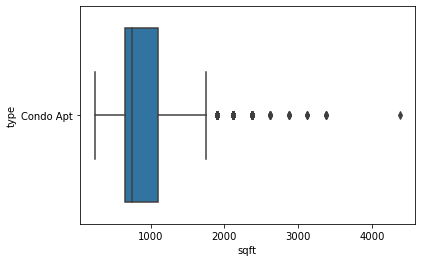

Semi-Detached  -  1435
Number of null values -  1067


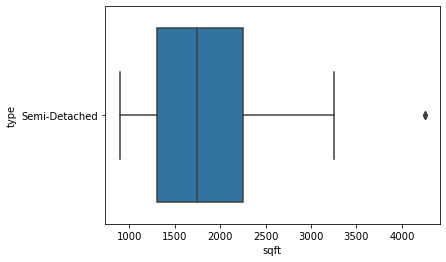

Detached  -  4361
Number of null values -  3144


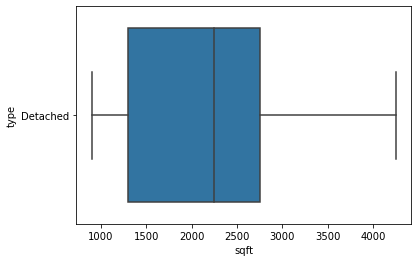

Condo Townhouse  -  1062
Number of null values -  0


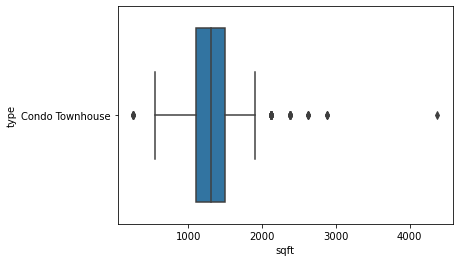

Plex  -  70
Number of null values -  43


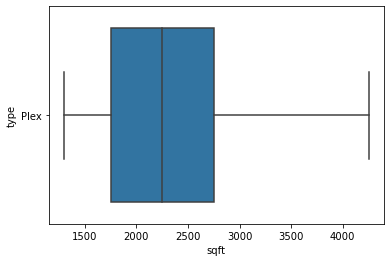

Att/Row/Twnhouse  -  467
Number of null values -  245


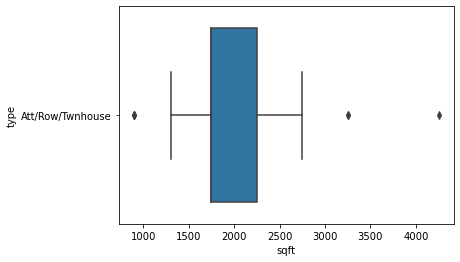

Comm Element Condo  -  181
Number of null values -  0


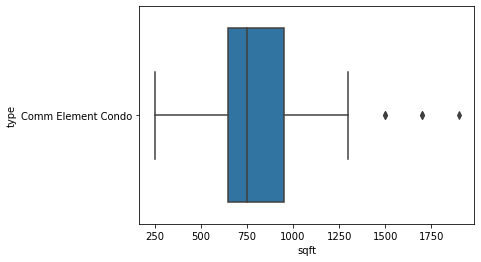

Link  -  27
Number of null values -  16


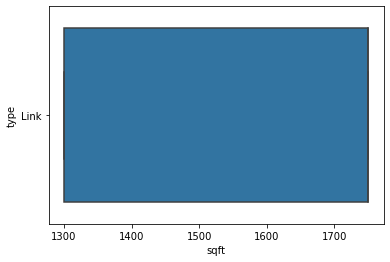

Co-Ownership Apt  -  27
Number of null values -  0


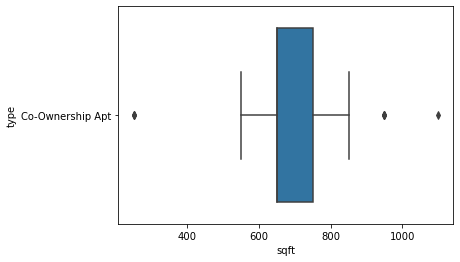

Co-Op Apt  -  24
Number of null values -  0


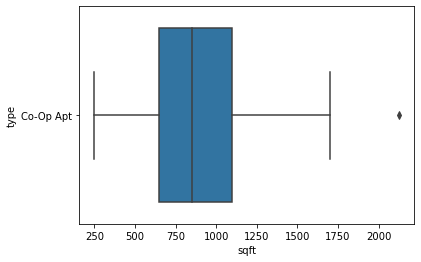

Store W/Apt/Offc  -  8
Number of null values -  6


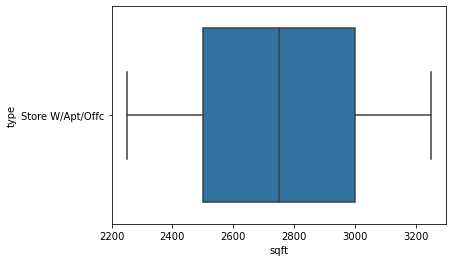

In [128]:
#checking distribution of square footage with respect to various variables

for i in df_repl.type.unique():
    
    print(i," - ", len(df_repl[df_repl['type'] == i]))
    print('Number of null values - ',df_repl[df_repl['type']==i].sqft.isnull().sum())
    sns.boxplot(y = df_repl[df_repl['type'] == i]['type'], x = df_repl.sqft)
    plt.show()


#### *** Since majority of the NaN values are present for the detached and semi detached type of homes, it is not practical to replace NaN values using metric such as mean or median. An XGBRegressor will be used to predict the missing Square Footage Values in order to make a Baseline model and hence, commence with new feature engineering and model optimization.

#### With all House types

In [139]:
#Train test split for prediction using all house types

test_data = df_repl[df_repl['sqft'].isnull()]
df_repl.dropna(inplace = True)

X_train = df_repl.drop('sqft',axis = 1)
X_test = test_data.drop('sqft',axis = 1)
y_train = df_repl['sqft']

In [161]:
import xgboost
from sklearn.preprocessing import OneHotEncoder

scaler = MinMaxScaler()

In [132]:
#Column Transformer and Creating Pipeline

preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), ['type','city_district']),
    ('sclaer', MinMaxScaler(), ['final_price', 'bathrooms', 'parking', 'bedroom', 'den'])])

from xgboost import XGBRegressor

pipeline = Pipeline(steps = [('features',preprocessor),
                            ('xgbregressor',XGBRegressor())])

In [133]:
#Fit the Pipeline and predict square foot values using all houses

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

XGBoostError: [23:35:39] C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/data/data.cc:481: Check failed: this->labels.Size() % this->num_row_ == 0 (5819 vs. 0) : Incorrect size for labels.

In [50]:
#preparing X_test and X_train for concatenation
X_test['sqft'] = y_pred
X_train['sqft'] = y_train

In [51]:
df_merged = pd.concat([X_train, X_test], ignore_index=False, sort=False)
df_merged

final_price  bathrooms  parking              type  \
0           855000          2        1         Condo Apt   
2           550000          1        0         Condo Apt   
3           665000          1        1         Condo Apt   
5           368000          1        1         Condo Apt   
6          2700000          5        2          Detached   
...            ...        ...      ...               ...   
15218      1595000          3        4          Detached   
15223      1222500          3        6          Detached   
15226      1050000          4        4          Detached   
15231       681000          3        1  Att/Row/Twnhouse   
15233       530000          2        4          Detached   

                city_district  bedroom  den         sqft  
0         Bay Street Corridor        2    1   850.000000  
2         Mount Pleasant West        1    0   550.000000  
3                     Niagara        1    1   650.000000  
5                 New Toronto        0    0   250.000000  
6         Lawrence Park South        4    0  2750.000000  
...                       ...      ...  ...          ...  
15218      Princess-Rosethorn        3    1  2399.219727  
15223          Bathurst Manor        3    1  1794.945190  
15226              L'Amoreaux        5    2  2892.250244  
15231  Centennial Scarborough        3    0  1695.414795  
15233   Birchcliffe-Cliffside        2    1  1086.917725  

[15234 rows x 8 columns]

In [52]:
## Merging newly predicted square footage values to orginal dataframe

# merge
dfx = pd.merge(df, df_merged[['sqft']], left_index = True,
    right_index = True)

# coalesce sqft column to get first non NA value
dfx['sqft'] = dfx['sqft_x'].combine_first(dfx['sqft_y']).astype('int64')

# remove the cols
dfx = dfx.drop(['sqft_x', 'sqft_y'], 1)

C:\Users\bevli\AppData\Local\Temp/ipykernel_2836/2869888798.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dfx = dfx.drop(['sqft_x', 'sqft_y'], 1)


In [60]:
dfx

final_price  bathrooms  parking  \
0           855000          2        1   
1           885000          2        6   
2           550000          1        0   
3           665000          1        1   
4           825513          2        1   
...            ...        ...      ...   
15229       785000          2        1   
15230      1025000          5        2   
15231       681000          3        1   
15232       590000          1        0   
15233       530000          2        4   

                                             description              type  \
0      Luxurious And Spacious Murano Tower. 2+1, 2 Ba...         Condo Apt   
1      Fantastic Opportunity To Live Within The Histo...     Semi-Detached   
2      Bright Sunfilled Spacious 1 Bdr Unit; Floor To...         Condo Apt   
3      Rare Loft-Like Condo In Liberty Village W/ 18'...         Condo Apt   
4      Location! Location! Location. Your Cottage In ...          Detached   
...                                                  ...               ...   
15229  Tableau Condo - Right In The Middle Of The Ent...         Condo Apt   
15230  New Years Special. Brand New House. Beautiful ...          Detached   
15231  Absolutely Beautiful **Freehold ** **End Unit*...  Att/Row/Twnhouse   
15232  One Year New Luxury Condo Built By Menkes. Hig...         Condo Apt   
15233  Great Builder Lot In Birchcliff Village. Can B...          Detached   

                                               full_link  \
0      https://www.zoocasa.com/toronto-on-real-estate...   
1      https://www.zoocasa.com/toronto-on-real-estate...   
2      https://www.zoocasa.com/toronto-on-real-estate...   
3      https://www.zoocasa.com/toronto-on-real-estate...   
4      https://www.zoocasa.com/toronto-on-real-estate...   
...                                                  ...   
15229  https://www.zoocasa.com/toronto-on-real-estate...   
15230  https://www.zoocasa.com/toronto-on-real-estate...   
15231  https://www.zoocasa.com/toronto-on-real-estate...   
15232  https://www.zoocasa.com/toronto-on-real-estate...   
15233  https://www.zoocasa.com/toronto-on-real-estate...   

                                         full_address        lat       long  \
0          38 Grenville St, Toronto , Ontario, Canada  43.661896 -79.385748   
1              2 Cabot Crt, Toronto , Ontario, Canada  43.646982 -79.530356   
2        30 Roehampton Ave, Toronto , Ontario, Canada  43.708472 -79.397498   
3       65 East Liberty St, Toronto , Ontario, Canada  43.638399 -79.414448   
4            61 Twelfth St, Toronto , Ontario, Canada  43.597096 -79.509612   
...                                               ...        ...        ...   
15229         125 Peter St, Toronto , Ontario, Canada  43.648317 -79.393065   
15230      179 Raleigh Ave, Toronto , Ontario, Canada  43.706338 -79.262789   
15231    68 Stagecoach Cir, Toronto , Ontario, Canada  43.788258 -79.160342   
15232        365 Church St, Toronto , Ontario, Canada  43.660846 -79.378756   
15233        43 Kalmar Ave, Toronto , Ontario, Canada  43.691296 -79.268417   

                           city_district  mean_district_income  district_code  \
0                    Bay Street Corridor                 56526             76   
1             Islington-City Centre West                 52787             14   
2                    Mount Pleasant West                 57039            104   
3                                Niagara                 70623             82   
4                            New Toronto                 44101             18   
...                                  ...                   ...            ...   
15229  Waterfront Communities-The Island                 70600             77   
15230                Clairlea-Birchmount                 36232            120   
15231             Centennial Scarborough                 54045            133   
15232              Church-Yonge Corridor                 53583             75   
1523

In [ ]:
####

In [ ]:
df_repl_2 = df.copy(deep = True)
df_repl_2.drop(['description','full_link','full_address', 'lat', 'long','district_code', 'mean_district_income','city_district' ],axis = 1, inplace = True)

In [ ]:
#Train test split for prediction using all house types 
#containing majority of the nan values

test_data2 = df_repl_2[df_repl_2['sqft'].isnull()]
df_repl_2.dropna(inplace = True)


X_train2 = df_repl_2[df_repl_2['type'].isin(['Detached','Plex','Semi-Detached','Att/Row/Twnhouse','Link','Store W/Apt/Offc'])].drop('sqft',axis = 1)
X_test2 = test_data2.drop('sqft',axis = 1)
y_train2 = df_repl_2[df_repl_2['type'].isin(['Detached','Plex','Semi-Detached','Att/Row/Twnhouse','Link','Store W/Apt/Offc'])]['sqft']


In [ ]:
import xgboost
from sklearn.preprocessing import OneHotEncoder

scaler = MinMaxScaler()

In [ ]:
#Column Transformer and Creating Pipeline 2

preprocessor2 = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), ['type']),
    ('sclaer', MinMaxScaler(), ['final_price', 'bathrooms', 'parking', 'bedroom', 'den'])])

from xgboost import XGBRegressor

pipeline2 = Pipeline(steps = [('features',preprocessor2),
                            ('xgbregressor',XGBRegressor())])

In [ ]:
#Fit the Pipeline and predict square foot values using nan houses

pipeline2.fit(X_train2, y_train2)
y_pred2 = pipeline2.predict(X_test2)

In [ ]:
#preparing X_test and X_train for concatenation using nan houses
X_test2['sqft'] = y_pred2
X_train2['sqft'] = y_train2

In [167]:
df_merged2 = pd.concat([X_train2, X_test2], ignore_index=False, sort=False)
df_merged2

final_price  bathrooms  parking              type  bedroom  den  \
6          2700000          5        2          Detached        4    0   
8           975000          2        1              Plex        2    0   
11         1530000          5        4          Detached        4    2   
12         2250000          4        2     Semi-Detached        3    1   
13         2100000          3        2          Detached        4    0   
...            ...        ...      ...               ...      ...  ...   
15218      1595000          3        4          Detached        3    1   
15223      1222500          3        6          Detached        3    1   
15226      1050000          4        4          Detached        5    2   
15231       681000          3        1  Att/Row/Twnhouse        3    0   
15233       530000          2        4          Detached        2    1   

              sqft  
6      2750.000000  
8      1300.000000  
11     3250.000000  
12     2750.000000  
13     1750.000000  
...            ...  
15218  2471.009521  
15223  1823.068970  
15226  2793.568359  
15231  1742.669312  
15233   957.391418  

[6368 rows x 7 columns]

In [168]:
## Merging newly predicted square footage values to orginal dataframe

# merge
dfx2 = pd.merge(df, df_merged2[['sqft']], left_index = True,
    right_index = True)

# coalesce sqft column to get first non NA value
dfx2['sqft'] = dfx2['sqft_x'].combine_first(dfx2['sqft_y']).astype('int64')

# remove the cols
dfx2 = dfx2.drop(['sqft_x', 'sqft_y'], 1)

C:\Users\bevli\AppData\Local\Temp/ipykernel_2836/163500469.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dfx2 = dfx2.drop(['sqft_x', 'sqft_y'], 1)


In [169]:
dfx2

final_price  bathrooms  parking  \
1           885000          2        6   
4           825513          2        1   
6          2700000          5        2   
8           975000          2        1   
10         1057000          2        1   
...            ...        ...      ...   
15223      1222500          3        6   
15226      1050000          4        4   
15230      1025000          5        2   
15231       681000          3        1   
15233       530000          2        4   

                                             description              type  \
1      Fantastic Opportunity To Live Within The Histo...     Semi-Detached   
4      Location! Location! Location. Your Cottage In ...          Detached   
6      Gorgeous Luxury Custom Built, 4 Bdrm Home On A...          Detached   
8      Location, Location, Detached Duplex In Fabulou...              Plex   
10     Excellently Preserved Semi-Detached Home Locat...     Semi-Detached   
...                                                  ...               ...   
15223  Attractive Brick Bungalow In High Demand Bathu...          Detached   
15226  L'amoreaux Community | Near Huntingwood And Bi...          Detached   
15230  New Years Special. Brand New House. Beautiful ...          Detached   
15231  Absolutely Beautiful **Freehold ** **End Unit*...  Att/Row/Twnhouse   
15233  Great Builder Lot In Birchcliff Village. Can B...          Detached   

                                               full_link  \
1      https://www.zoocasa.com/toronto-on-real-estate...   
4      https://www.zoocasa.com/toronto-on-real-estate...   
6      https://www.zoocasa.com/toronto-on-real-estate...   
8      https://www.zoocasa.com/toronto-on-real-estate...   
10     https://www.zoocasa.com/toronto-on-real-estate...   
...                                                  ...   
15223  https://www.zoocasa.com/toronto-on-real-estate...   
15226  https://www.zoocasa.com/toronto-on-real-estate...   
15230  https://www.zoocasa.com/toronto-on-real-estate...   
15231  https://www.zoocasa.com/toronto-on-real-estate...   
15233  https://www.zoocasa.com/toronto-on-real-estate...   

                                          full_address        lat       long  \
1               2 Cabot Crt, Toronto , Ontario, Canada  43.646982 -79.530356   
4             61 Twelfth St, Toronto , Ontario, Canada  43.597096 -79.509612   
6          110 Albertus Ave, Toronto , Ontario, Canada  43.714068 -79.403338   
8          182 Broadway Ave, Toronto , Ontario, Canada  43.711472 -79.390394   
10     342 Indian Road Cres, Toronto , Ontario, Canada  43.664541 -79.461476   
...                                                ...        ...        ...   
15223      334 Waterloo Ave, Toronto , Ontario, Canada  43.754819 -79.462852   
15226        27 Harfleur Rd, Toronto , Ontario, Canada  43.793412 -79.300010   
15230       179 Raleigh Ave, Toronto , Ontario, Canada  43.706338 -79.262789   
15231     68 Stagecoach Cir, Toronto , Ontario, Canada  43.788258 -79.160342   
15233         43 Kalmar Ave, Toronto , Ontario, Canada  43.691296 -79.268417   

                    city_district  mean_district_income  district_code  \
1      Islington-City Centre West                 52787             14   
4                     New Toronto                 44101             18   
6             Lawrence Park South                169203            103   
8             Mount Pleasant East                 85340             99   
10                  Junction Area                 49709             90   
...                           ...                   ...            ...   
15223              Bathurst Manor                 45936             34   
15226                  L'Amoreaux                 31826            117   
15230         Clairlea-Birchmount                 36232            120   
15231      Centennial Scarborough                 54045            133   
15233       Birchcliffe-Cliffside                 54360            12

### Baseline model

In [62]:
X = dfx[['bathrooms', 'parking', 'type',
       'city_district','mean_district_income','bedroom', 'den', 'sqft']]

y = dfx[['final_price']]

In [63]:
#train test split

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state = 42)

In [64]:
#Column Transformer and Creating Pipeline

preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), ['type','city_district']),
    ('scaler', MinMaxScaler(), ['bathrooms', 'parking', 'bedroom', 'den',
                               'sqft','mean_district_income',])])

from xgboost import XGBRegressor

pipeline = Pipeline(steps = [('features',preprocessor),
                            ('xgbregressor',XGBRegressor(objective='reg:squarederror'))])

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [66]:
#parameters for gridsearch

base_model = LinearRegression()
ridge = Ridge()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
xgb = XGBRegressor()

models = [ridge, rfr, gbr]

params = [{
           'models':[ridge],
           'models__alpha':[0.001,0.01,0.1,1,10]
          },
          {
        'models':[rfr],
        "models__n_estimators":[100, 150, 200],
        "models__max_depth":[5,7, 10]
        
    },
    {
        'models':[gbr],
        "models__learning_rate":[0.1, 0.2, 0.3],
        "models__n_estimators":[100, 150, 200],
        "models__max_depth":[5,7, 10]
    },
    {
        'models':[xgb],
        'models__learning_rate': [0.01, 0.1, 0.4, 0.8],
        'models__colsample_bytree': [0.6, 0.8, 1.0],
        'models__max_depth': [3, 5, 8, 12],
        'models__reg_alpha':[0,0.1,0.4,1.6,12.8, 51.2],
        'models__n_estimators':[50,100,200],
    }]

final_pipeline = Pipeline(steps = [('features',preprocessor),('models',base_model)])


In [69]:
#fitting gridsearchCV

gridsearch = GridSearchCV(final_pipeline, params,scoring = ['neg_mean_squared_error', 'r2'], verbose=5, refit = 'r2').fit(X_train, y_train)


Fitting 5 folds for each of 905 candidates, totalling 4525 fits
[CV 1/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-73941909927.120) r2: (test=0.791) total time=   0.0s
[CV 2/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-65239343959.414) r2: (test=0.810) total time=   0.0s
[CV 3/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-60237387467.207) r2: (test=0.819) total time=   0.0s
[CV 4/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-103997577939.591) r2: (test=0.740) total time=   0.0s
[CV 5/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-87088527461.451) r2: (test=0.794) total time=   0.0s
[CV 1/5] END models=Ridge(), models__alpha=0.01; neg_mean_squared_error: (test=-73940441308.832) r2: (test=0.791) total time=   0.0s
[CV 2/5] END models=Ridge(), models__alpha=0.01; neg_mean_squared_error: (test=-65238307208.340) r2: (test=0.810) total time=   0.0s

C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-69172451287.643) r2: (test=0.805) total time=   1.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-66908954306.809) r2: (test=0.805) total time=   1.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-57567124927.127) r2: (test=0.827) total time=   1.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-90645249973.809) r2: (test=0.774) total time=   1.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-75291717317.827) r2: (test=0.822) total time=   1.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-69770746528.827) r2: (test=0.803) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-68040675421.277) r2: (test=0.801) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-57895860752.596) r2: (test=0.826) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-88249003917.684) r2: (test=0.780) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-76255900617.895) r2: (test=0.819) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-69288086859.791) r2: (test=0.805) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-67432024973.683) r2: (test=0.803) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-57203840943.919) r2: (test=0.828) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-91145589779.046) r2: (test=0.772) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-75211699554.607) r2: (test=0.822) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-58937842278.066) r2: (test=0.834) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-61210147013.609) r2: (test=0.821) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-51715247091.397) r2: (test=0.844) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-83808389243.646) r2: (test=0.791) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-73447144990.612) r2: (test=0.826) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-57881105682.331) r2: (test=0.837) total time=   3.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-61153865629.878) r2: (test=0.821) total time=   3.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-52316236841.176) r2: (test=0.843) total time=   3.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-81863362869.534) r2: (test=0.796) total time=   3.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-72850533141.673) r2: (test=0.827) total time=   3.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-57669039784.431) r2: (test=0.837) total time=   4.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-60797076819.262) r2: (test=0.823) total time=   4.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-51381813368.264) r2: (test=0.845) total time=   4.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-82901622579.643) r2: (test=0.793) total time=   4.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-73157980423.445) r2: (test=0.827) total time=   4.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-50120586540.496) r2: (test=0.859) total time=   4.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-55586852931.531) r2: (test=0.838) total time=   4.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-43560222481.969) r2: (test=0.869) total time=   4.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-75956934734.848) r2: (test=0.810) total time=   4.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-68114430477.433) r2: (test=0.839) total time=   4.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-50083423948.092) r2: (test=0.859) total time=   6.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-54806733166.765) r2: (test=0.840) total time=   6.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-44318240654.952) r2: (test=0.867) total time=   6.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-75510185214.882) r2: (test=0.811) total time=   6.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-68554335447.316) r2: (test=0.838) total time=   6.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-50213521310.489) r2: (test=0.858) total time=   9.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-54870721157.928) r2: (test=0.840) total time=   9.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-43786684323.510) r2: (test=0.868) total time=   8.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-75852584629.186) r2: (test=0.811) total time=   9.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-67623782856.710) r2: (test=0.840) total time=   9.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-47725406166.176) r2: (test=0.865) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-60277541241.814) r2: (test=0.824) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-47716349674.936) r2: (test=0.857) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-58808103347.658) r2: (test=0.853) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-64575517453.866) r2: (test=0.847) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-45497058677.926) r2: (test=0.872) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-57574903224.895) r2: (test=0.832) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-43794248081.267) r2: (test=0.868) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-56733721649.957) r2: (test=0.858) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-65323473678.767) r2: (test=0.845) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-44267515937.131) r2: (test=0.875) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-55375137404.237) r2: (test=0.838) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-45542698270.930) r2: (test=0.863) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-55938916978.664) r2: (test=0.860) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-62217007934.977) r2: (test=0.853) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-45139579433.633) r2: (test=0.873) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-54104808067.894) r2: (test=0.842) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-43232957344.253) r2: (test=0.870) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-61529046799.057) r2: (test=0.846) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-71959955475.870) r2: (test=0.830) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-44009355805.555) r2: (test=0.876) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-53018399726.331) r2: (test=0.845) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-42924374960.260) r2: (test=0.871) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-61340016641.439) r2: (test=0.847) total time=   1.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-71385549957.036) r2: (test=0.831) total time=   1.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-43935639640.929) r2: (test=0.876) total time=   2.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-53333410104.938) r2: (test=0.844) total time=   2.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-41938792067.632) r2: (test=0.874) total time=   2.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-62070025168.029) r2: (test=0.845) total time=   2.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-71949270532.735) r2: (test=0.830) total time=   2.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-46873451020.611) r2: (test=0.868) total time=   2.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-59297030334.108) r2: (test=0.827) total time=   2.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-41200460858.875) r2: (test=0.876) total time=   2.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-81050096188.533) r2: (test=0.798) total time=   2.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-108015375715.048) r2: (test=0.744) total time=   2.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-47494865174.932) r2: (test=0.866) total time=   3.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-57726007936.541) r2: (test=0.831) total time=   3.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-46940850895.956) r2: (test=0.859) total time=   3.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-81836540592.973) r2: (test=0.796) total time=   3.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-110911938479.379) r2: (test=0.737) total time=   3.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-46570303073.294) r2: (test=0.869) total time=   4.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-57239887573.290) r2: (test=0.833) total time=   4.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-42524593177.261) r2: (test=0.872) total time=   4.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-81601776713.466) r2: (test=0.796) total time=   4.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-110888147773.987) r2: (test=0.737) total time=   4.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-44145197374.405) r2: (test=0.875) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-55810442147.787) r2: (test=0.837) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-39637507448.837) r2: (test=0.881) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-59588237884.383) r2: (test=0.851) total time=   0.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-61395761010.255) r2: (test=0.855) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-43329635585.509) r2: (test=0.878) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-54318568252.399) r2: (test=0.841) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-40099495019.466) r2: (test=0.879) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-59195932883.832) r2: (test=0.852) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-60807828195.768) r2: (test=0.856) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-42443033937.407) r2: (test=0.880) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-56976798115.194) r2: (test=0.834) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-35229222567.100) r2: (test=0.894) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-59790586337.004) r2: (test=0.851) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-59939694450.224) r2: (test=0.858) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-42972014325.015) r2: (test=0.879) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-51745559603.754) r2: (test=0.849) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-41513187493.562) r2: (test=0.875) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-63482906674.035) r2: (test=0.842) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-66020821151.681) r2: (test=0.844) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-42577393455.922) r2: (test=0.880) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-53181948113.862) r2: (test=0.845) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-39866754818.950) r2: (test=0.880) total time=   1.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-63433329199.105) r2: (test=0.842) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-65856205105.866) r2: (test=0.844) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-43263844587.940) r2: (test=0.878) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-55459835936.201) r2: (test=0.838) total time=   2.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-39143768354.284) r2: (test=0.882) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-64175728178.662) r2: (test=0.840) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-68033180078.551) r2: (test=0.839) total time=   2.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-48951302167.366) r2: (test=0.862) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-55542623115.723) r2: (test=0.838) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-40534485304.380) r2: (test=0.878) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-80782744497.219) r2: (test=0.798) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-98283285246.622) r2: (test=0.767) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-49262976014.471) r2: (test=0.861) total time=   3.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-56356317617.693) r2: (test=0.835) total time=   3.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-39419761406.543) r2: (test=0.881) total time=   3.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-81237015205.429) r2: (test=0.797) total time=   3.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-100031350690.011) r2: (test=0.763) total time=   3.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-48772574499.923) r2: (test=0.862) total time=   3.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-54558843225.999) r2: (test=0.841) total time=   4.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-42483790730.801) r2: (test=0.872) total time=   3.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-81801256935.170) r2: (test=0.796) total time=   3.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-102373167043.496) r2: (test=0.757) total time=   3.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-42030619854.809) r2: (test=0.881) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-53103788809.900) r2: (test=0.845) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-41439919000.641) r2: (test=0.875) total time=   0.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-57880126311.967) r2: (test=0.855) total time=   0.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-63892890751.821) r2: (test=0.849) total time=   0.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-41273023370.350) r2: (test=0.884) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-55795125420.646) r2: (test=0.837) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-43011543725.303) r2: (test=0.871) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-62987957896.564) r2: (test=0.843) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-64313719233.929) r2: (test=0.848) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-42054943018.319) r2: (test=0.881) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-55736733212.346) r2: (test=0.837) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-43322715602.106) r2: (test=0.870) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-60117950481.574) r2: (test=0.850) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-67128101842.096) r2: (test=0.841) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-42951079102.934) r2: (test=0.879) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-55335420856.935) r2: (test=0.838) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-45444266680.051) r2: (test=0.863) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-59844888417.857) r2: (test=0.851) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-73821821242.425) r2: (test=0.825) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-44097081144.487) r2: (test=0.876) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-57704000879.021) r2: (test=0.832) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-43020237462.027) r2: (test=0.871) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-61612904678.758) r2: (test=0.846) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-74671074625.367) r2: (test=0.823) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-44710895898.113) r2: (test=0.874) total time=   2.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-57771061940.293) r2: (test=0.831) total time=   2.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-48152104435.926) r2: (test=0.855) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-62897967261.862) r2: (test=0.843) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-71432895492.420) r2: (test=0.831) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-49243669378.294) r2: (test=0.861) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-57912980709.163) r2: (test=0.831) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-44218899677.707) r2: (test=0.867) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-85131562979.062) r2: (test=0.787) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-111153772315.429) r2: (test=0.737) total time=   1.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-49157815394.486) r2: (test=0.861) total time=   2.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-55877747355.503) r2: (test=0.837) total time=   2.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-44200288035.016) r2: (test=0.867) total time=   3.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-89198597158.460) r2: (test=0.777) total time=   2.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-109779181998.365) r2: (test=0.740) total time=   2.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-48551938008.494) r2: (test=0.863) total time=   3.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-60028209012.075) r2: (test=0.825) total time=   3.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-41588948923.855) r2: (test=0.875) total time=   4.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-88905512393.580) r2: (test=0.778) total time=   4.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-111397384967.225) r2: (test=0.736) total time=   4.0s
[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__le

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-540953941641.641) r2: (test=-0.281) total time=   0.0s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-526920768198.984) r2: (test=-0.316) total time=   0.0s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-458523812995.006) r2: (test=-0.379) total time=   0.0s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-232626258351.748) r2: (test=0.321) total time=   0.0s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-232626258748.214) r2: (test=0.321) total time=   0.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-232626295976.164) r2: (test=0.321) total time=   0.0s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-103324285400.607) r2: (test=0.709) total time=   0.2s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-116147708346.247) r2: (test=0.725) total time=   0.2s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-120616011152.622) r2: (test=0.699) total time=   0.1s
[CV 5/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-516601087660.003) r2: (test=-0.290) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-516601087911.299) r2: (test=-0.290) total time=   0.0s
[CV 5/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-516601118432.257) r2: (test=-0.290) total time=   0.0s
[CV 5/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-256360118437.928) r2: (test=0.360) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-201376137061.491) r2: (test=0.394) total time=   0.1s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-214800438792.122) r2: (test=0.373) total time=   0.1s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-85982090875.403) r2: (test=0.757) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-101761082191.896) r2: (test=0.759) total time=   0.3s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-107921272318.038) r2: (test=0.731) total time=   0.3s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-69014540115.284) r2: (test=0.792) total time=   0.3s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-459832796227.375) r2: (test=-0.342) total time=   0.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-459832893686.825) r2: (test=-0.342) total time=   0.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-459822979459.070) r2: (test=-0.342) total time=   0.1s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-216028187772.438) r2: (test=0.391) total time=   0.2s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-247708093301.467) r2: (test=0.413) total time=   0.3s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-253901690210.270) r2: (test=0.366) total time=   0.2s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-61447517029.374) r2: (test=0.815) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-73674903466.297) r2: (test=0.785) total time=   0.6s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-76755003478.005) r2: (test=0.783) total time=   0.5s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-94893336074.831) r2: (test=0.775) total time=   0.6s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-511805611516.640) r2: (test=-0.278) total time=   0.1s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-443808710698.804) r2: (test=-0.335) total time=   0.2s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-457788771608.844) r2: (test=-0.336) total time=   0.1s
[CV 3/5] END models=XGBRegressor(b

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-213590561532.209) r2: (test=0.397) total time=   0.4s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-245392853237.532) r2: (test=0.419) total time=   0.4s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-251701753424.671) r2: (test=0.372) total time=   0.4s
[CV 5/5] END models=XGBRegressor(b

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-58736992533.999) r2: (test=0.823) total time=   0.9s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-70888295141.059) r2: (test=0.793) total time=   0.9s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-73909628905.969) r2: (test=0.791) total time=   1.2s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-92121124059.233) r2: (test=0.782) total time=   1.0s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-73066713681.974) r2: (test=0.818) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-52722131120.020) r2: (test=0.841) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-73066814218.311) r2: (test=0.818) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-65706249859.677) r2: (test=0.836) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-65706253705.411) r2: (test=0.836) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-65706379156.883) r2: (test=0.836) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-45063168343.016) r2: (test=0.864) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-58363015048.419) r2: (test=0.830) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-53210218626.615) r2: (test=0.850) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-52044251320.540) r2: (test=0.853) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-52044251402.773) r2: (test=0.853) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-52044295864.522) r2: (test=0.853) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-56396843524.053) r2: (test=0.866) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-55036496511.983) r2: (test=0.863) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-55036542958.528) r2: (test=0.863) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-39306912060.404) r2: (test=0.882) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-50062402153.306) r2: (test=0.854) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-45839586610.721) r2: (test=0.871) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-55075209185.335) r2: (test=0.870) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-58307030563.512) r2: (test=0.862) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-58307037575.985) r2: (test=0.862) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-58307152926.291) r2: (test=0.862) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-54225997955.394) r2: (test=0.865) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-36443372577.292) r2: (test=0.890) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51792469554.676) r2: (test=0.849) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-41633280522.430) r2: (test=0.883) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-56027051649.248) r2: (test=0.867) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-53255700540.838) r2: (test=0.867) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-36139743251.066) r2: (test=0.891) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-51538744667.822) r2: (test=0.850) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-44399530683.507) r2: (test=0.875) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-58391011867.304) r2: (test=0.862) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-61936060553.268) r2: (test=0.845) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-37460518617.172) r2: (test=0.887) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-53817662939.661) r2: (test=0.843) total time=   0.4s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-44258106335.290) r2: (test=0.875) total time=   0.9s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-58374583925.516) r2: (test=0.862) total time=   0.8s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-61732446491.720) r2: (test=0.846) total time=   0.9s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-51245374743.292) r2: (test=0.846) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-59899348888.043) r2: (test=0.825) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-54095993583.062) r2: (test=0.847) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-69997102839.330) r2: (test=0.834) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-65842493891.740) r2: (test=0.844) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-65842497351.702) r2: (test=0.844) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-65842415221.181) r2: (test=0.844) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-53489115894.699) r2: (test=0.866) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-43384282197.699) r2: (test=0.870) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-58033185342.260) r2: (test=0.831) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-48708441312.937) r2: (test=0.863) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-48708443015.086) r2: (test=0.863) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-48708506962.425) r2: (test=0.863) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-51614343625.836) r2: (test=0.878) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-51868963906.343) r2: (test=0.871) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-37386504756.039) r2: (test=0.888) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-51532722240.236) r2: (test=0.850) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-47235718936.831) r2: (test=0.867) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-53783698740.310) r2: (test=0.873) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51540946502.673) r2: (test=0.871) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-42757894262.785) r2: (test=0.871) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-42757892639.532) r2: (test=0.871) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-42748809556.944) r2: (test=0.871) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-51245767295.231) r2: (test=0.850) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-43223328481.276) r2: (test=0.878) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-58791587961.064) r2: (test=0.861) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-58101773614.437) r2: (test=0.855) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-41986728492.232) r2: (test=0.874) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-52137011898.315) r2: (test=0.848) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-48939129379.048) r2: (test=0.862) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-61478750339.830) r2: (test=0.854) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-60407851075.479) r2: (test=0.849) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-44843775608.370) r2: (test=0.865) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-56209675309.549) r2: (test=0.836) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-50299309700.947) r2: (test=0.858) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-62222710686.092) r2: (test=0.853) total time=   0.4s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-62444420060.983) r2: (test=0.844) total time=   0.8s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-48339494625.714) r2: (test=0.855) total time=   0.7s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-57625495469.217) r2: (test=0.832) total time=   0.7s
[CV 3/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-53532795406.134) r2: (test=0.839) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-59759981128.200) r2: (test=0.826) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-49794733560.113) r2: (test=0.860) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-71771310403.787) r2: (test=0.830) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-69634742572.357) r2: (test=0.835) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-69634747486.226) r2: (test=0.835) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-69634514474.936) r2: (test=0.835) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-57519024757.853) r2: (test=0.856) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-44788795869.628) r2: (test=0.865) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-60544892572.637) r2: (test=0.823) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-50147093456.153) r2: (test=0.859) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-50147084367.652) r2: (test=0.859) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-50146928326.973) r2: (test=0.859) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-59870853561.913) r2: (test=0.858) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-58487318787.383) r2: (test=0.854) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-49067700574.626) r2: (test=0.852) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-65804859741.652) r2: (test=0.808) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-53842823191.644) r2: (test=0.848) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-61621087740.083) r2: (test=0.854) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-56552571216.256) r2: (test=0.859) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-45682852767.164) r2: (test=0.863) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-45682845062.742) r2: (test=0.863) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-45682587815.834) r2: (test=0.863) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-74249084385.338) r2: (test=0.783) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-59430257632.033) r2: (test=0.832) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-72219190114.305) r2: (test=0.829) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-68455954948.900) r2: (test=0.829) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-48860464023.227) r2: (test=0.853) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-74648416627.957) r2: (test=0.782) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-62966146298.582) r2: (test=0.822) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-85498760744.205) r2: (test=0.797) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-74350936988.986) r2: (test=0.814) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-60008813957.738) r2: (test=0.820) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-72055758966.342) r2: (test=0.790) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-64214355386.838) r2: (test=0.819) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-86626441937.987) r2: (test=0.795) total time=   0.4s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-76522526095.273) r2: (test=0.809) total time=   0.8s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-60783743169.195) r2: (test=0.817) total time=   0.8s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-72546884149.799) r2: (test=0.788) total time=   0.8s
[CV 3/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-452307767451.067) r2: (test=-0.360) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-471231889950.021) r2: (test=-0.376) total time=   0.0s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-479316297356.639) r2: (test=-0.352) total time=   0.0s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-531136553725.510) r2: (test=-0.258) total time=   0.0s
[CV 1/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-263543717651.458) r2: (test=0.376) total time=   0.1s
[CV 1/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-263543719046.238) r2: (test=0.376) total time=   0.1s
[CV 1/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-263543780228.606) r2: (test=0.376) total time=   0.1s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-116788865632.204) r2: (test=0.708) total time=   0.2s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-79567419308.905) r2: (test=0.761) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-93340983375.604) r2: (test=0.727) total time=   0.2s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-463138147754.011) r2: (test=-0.307) total time=   0.0s
[CV 2/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-463138151423.855) r2: (test=-0.307) total time=   0.0s
[CV 2/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-463137531951.345) r2: (test=-0.307) total time=   0.0s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-246555170181.386) r2: (test=0.416) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-247976668315.251) r2: (test=0.381) total time=   0.1s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-195835386006.016) r2: (test=0.411) total time=   0.2s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-79786176129.980) r2: (test=0.767) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-83831935860.968) r2: (test=0.764) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-98243546742.662) r2: (test=0.767) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-102038191368.840) r2: (test=0.745) total time=   0.4s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-438388655938.002) r2: (test=-0.318) total time=   0.1s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-452521671703.203) r2: (test=-0.321) total time=   0.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-459554678511.204) r2: (test=-0.296) total time=   0.1s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-242046240918.773) r2: (test=0.427) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-247502436035.762) r2: (test=0.382) total time=   0.3s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-190778719299.263) r2: (test=0.426) total time=   0.3s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-71698782138.119) r2: (test=0.791) total time=   0.7s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-74240182149.647) r2: (test=0.791) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-90993542392.144) r2: (test=0.784) total time=   0.7s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-97169285593.722) r2: (test=0.757) total time=   0.7s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-436910691229.578) r2: (test=-0.314) total time=   0.2s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-451559332632.167) r2: (test=-0.318) total time=   0.2s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-458038227695.407) r2: (test=-0.292) total time=   0.2s
[CV 2/5] END models=XGBRegressor(b

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-238754367636.229) r2: (test=0.434) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-246964390853.587) r2: (test=0.383) total time=   0.5s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-188860576001.437) r2: (test=0.432) total time=   0.4s
[CV 4/5] END models=XGBRegressor(b

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-69542472779.861) r2: (test=0.797) total time=   1.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-72122754509.960) r2: (test=0.797) total time=   1.0s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-88352871936.602) r2: (test=0.791) total time=   1.1s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-96173255698.334) r2: (test=0.760) total time=   1.0s
[CV 5/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-74739948097.140) r2: (test=0.813) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-52705544293.546) r2: (test=0.842) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-65951504476.412) r2: (test=0.807) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-57390942023.766) r2: (test=0.838) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-57390944782.290) r2: (test=0.838) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-57390996676.319) r2: (test=0.838) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-64186969633.628) r2: (test=0.848) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-61209528882.329) r2: (test=0.847) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-47106040475.432) r2: (test=0.858) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-59339460615.378) r2: (test=0.827) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-59339459795.703) r2: (test=0.827) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-59339451815.584) r2: (test=0.827) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-47009991013.012) r2: (test=0.867) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-59477691695.823) r2: (test=0.859) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-60828995003.317) r2: (test=0.848) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-43981300074.056) r2: (test=0.868) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-55044178395.740) r2: (test=0.839) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-44394933894.055) r2: (test=0.875) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-57541208019.176) r2: (test=0.864) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-62054782804.358) r2: (test=0.845) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sco

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-62054784537.956) r2: (test=0.845) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-42307027589.365) r2: (test=0.873) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-54762520641.591) r2: (test=0.840) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-40980969789.434) r2: (test=0.884) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-57328465480.409) r2: (test=0.864) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-59089203340.960) r2: (test=0.852) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-40960281844.305) r2: (test=0.877) total time=   0.6s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-54992763197.227) r2: (test=0.839) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-40450451312.289) r2: (test=0.886) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-60295868816.877) r2: (test=0.857) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-63067916961.411) r2: (test=0.843) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-42460045360.984) r2: (test=0.872) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-55959626537.055) r2: (test=0.837) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-44919071973.243) r2: (test=0.873) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-60576060418.278) r2: (test=0.857) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-59911135276.514) r2: (test=0.850) total time=   0.5s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-44148790811.681) r2: (test=0.867) total time=   0.9s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-56722514242.750) r2: (test=0.834) total time=   0.9s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-45364328190.532) r2: (test=0.872) total time=   0.9s
[CV 2/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-54780764363.314) r2: (test=0.845) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-62432464692.963) r2: (test=0.852) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-59851348979.005) r2: (test=0.851) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-57352601844.757) r2: (test=0.857) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-57352602942.314) r2: (test=0.857) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-57352627190.531) r2: (test=0.857) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-39814133943.877) r2: (test=0.880) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-56890941110.049) r2: (test=0.834) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-44711265759.559) r2: (test=0.874) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-58332850322.771) r2: (test=0.862) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-69993022252.911) r2: (test=0.834) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-69993023884.445) r2: (test=0.834) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-69992921829.444) r2: (test=0.834) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-60562551966.939) r2: (test=0.849) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-44467716743.377) r2: (test=0.866) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-54463393023.867) r2: (test=0.841) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-40459331920.334) r2: (test=0.886) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-70965694163.929) r2: (test=0.832) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-59930930285.595) r2: (test=0.850) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-61159477074.918) r2: (test=0.847) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sco

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-61159469053.726) r2: (test=0.847) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-41075428653.137) r2: (test=0.876) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-58514281842.406) r2: (test=0.829) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-44418829145.334) r2: (test=0.875) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-73871333674.190) r2: (test=0.825) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-61334863915.019) r2: (test=0.847) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-46511206973.480) r2: (test=0.860) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-58983045063.479) r2: (test=0.828) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47327271273.377) r2: (test=0.866) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-71659848656.359) r2: (test=0.830) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-74236637001.676) r2: (test=0.815) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-47018836084.657) r2: (test=0.859) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-61408243041.622) r2: (test=0.821) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-47551254175.449) r2: (test=0.866) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-73603654252.890) r2: (test=0.826) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-75891238683.635) r2: (test=0.811) total time=   0.4s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-48854686738.178) r2: (test=0.853) total time=   0.9s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-62057127756.757) r2: (test=0.819) total time=   0.8s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-50204505785.761) r2: (test=0.858) total time=   0.9s
[CV 2/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-54390778349.604) r2: (test=0.847) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-72631155737.417) r2: (test=0.828) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-56965734885.898) r2: (test=0.858) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-56625933639.839) r2: (test=0.859) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-56625936548.511) r2: (test=0.859) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-56625882870.727) r2: (test=0.859) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-46992252281.606) r2: (test=0.859) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-55562950204.447) r2: (test=0.838) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-48144498137.602) r2: (test=0.864) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-71396435723.964) r2: (test=0.831) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-66634463322.486) r2: (test=0.842) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-66634459213.579) r2: (test=0.842) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-66942719933.426) r2: (test=0.841) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-89019977065.292) r2: (test=0.778) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-50092841184.571) r2: (test=0.849) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-63151107121.932) r2: (test=0.816) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-56239325793.624) r2: (test=0.841) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-71221825568.081) r2: (test=0.831) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-91302294033.870) r2: (test=0.772) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-74143605666.431) r2: (test=0.815) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sco

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-74143603370.343) r2: (test=0.815) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-74143345709.182) r2: (test=0.815) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-49548188635.551) r2: (test=0.851) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-61815234303.909) r2: (test=0.820) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-49049466859.707) r2: (test=0.862) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-71235400166.482) r2: (test=0.831) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-77364914230.916) r2: (test=0.807) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-50004785497.687) r2: (test=0.850) total time=   0.6s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-63948541583.212) r2: (test=0.813) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-52822894980.563) r2: (test=0.851) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-69977311470.665) r2: (test=0.834) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-70611687302.714) r2: (test=0.824) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-52705449879.794) r2: (test=0.842) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-59918910430.668) r2: (test=0.825) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-54088325418.716) r2: (test=0.847) total time=   0.4s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-70801206808.858) r2: (test=0.832) total time=   0.6s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-71850935707.931) r2: (test=0.821) total time=   0.9s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-53001397089.359) r2: (test=0.841) total time=   0.9s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-59456442012.646) r2: (test=0.826) total time=   0.9s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-475942216407.368) r2: (test=-0.343) total time=   0.0s
[CV 2/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-467670553665.673) r2: (test=-0.365) total time=   0.0s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-475942242568.241) r2: (test=-0.343) total time=   0.0s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-258283378789.817) r2: (test=0.388) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-258283378789.817) r2: (test=0.388) total time=   0.1s
[CV 1/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-258283397330.768) r2: (test=0.388) total time=   0.1s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-116812155958.513) r2: (test=0.708) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-79966193792.977) r2: (test=0.760) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-93480106677.838) r2: (test=0.727) total time=   0.2s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-451785250144.565) r2: (test=-0.319) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-451785253519.614) r2: (test=-0.319) total time=   0.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-451793519810.576) r2: (test=-0.319) total time=   0.1s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-216817417804.426) r2: (test=0.388) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-240542516269.565) r2: (test=0.430) total time=   0.2s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-241507794544.928) r2: (test=0.397) total time=   0.2s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-192855947662.111) r2: (test=0.420) total time=   0.2s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-81504878947.964) r2: (test=0.762) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-84435108406.765) r2: (test=0.762) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-96600782980.037) r2: (test=0.771) total time=   0.4s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-503153984696.627) r2: (test=-0.256) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-436697085257.546) r2: (test=-0.313) total time=   0.2s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-448856247245.629) r2: (test=-0.310) total time=   0.1s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-211884791082.717) r2: (test=0.402) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-237845021303.402) r2: (test=0.437) total time=   0.3s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-242787730925.556) r2: (test=0.394) total time=   0.3s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-188829550665.989) r2: (test=0.432) total time=   0.4s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-71543764387.831) r2: (test=0.791) total time=   0.7s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-76916153208.265) r2: (test=0.783) total time=   0.7s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-90694553267.862) r2: (test=0.785) total time=   0.8s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-503263574556.145) r2: (test=-0.256) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-436139923357.266) r2: (test=-0.311) total time=   0.2s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-449023994229.164) r2: (test=-0.311) total time=   0.2s
[CV 3/5] END models=XGBRegressor(b

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-211205957318.600) r2: (test=0.404) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-235811980579.112) r2: (test=0.441) total time=   0.5s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-244359918050.248) r2: (test=0.390) total time=   0.6s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-190289163099.790) r2: (test=0.428) total time=   0.6s
[CV 4/5] END models=XGBRegressor(b

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-70238252781.114) r2: (test=0.795) total time=   1.3s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-74856051425.902) r2: (test=0.789) total time=   1.4s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-90408255889.077) r2: (test=0.786) total time=   1.3s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-75194481874.534) r2: (test=0.812) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_sco

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-75194482491.321) r2: (test=0.812) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-54275734976.424) r2: (test=0.837) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-51676366772.131) r2: (test=0.845) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-51676364041.299) r2: (test=0.845) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-51676360611.828) r2: (test=0.845) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-55296128267.215) r2: (test=0.839) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-52610932950.946) r2: (test=0.852) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-64679416062.315) r2: (test=0.847) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-61449094292.867) r2: (test=0.847) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-47955154167.469) r2: (test=0.856) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-47955148707.083) r2: (test=0.856) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47967305975.712) r2: (test=0.856) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-56056297927.056) r2: (test=0.836) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-46466646722.261) r2: (test=0.869) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-59115860272.112) r2: (test=0.860) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-58605348344.863) r2: (test=0.854) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-43234117837.733) r2: (test=0.870) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-54276875898.727) r2: (test=0.842) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-46069894003.345) r2: (test=0.870) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_sco

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-59284629447.905) r2: (test=0.860) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-68094448574.886) r2: (test=0.830) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-41589103539.825) r2: (test=0.875) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-55939363349.864) r2: (test=0.837) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-43784053394.464) r2: (test=0.876) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-57755532074.098) r2: (test=0.863) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-65483581887.858) r2: (test=0.837) total time=   0.7s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-41660667992.525) r2: (test=0.875) total time=   0.6s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-55646198213.733) r2: (test=0.838) total time=   0.7s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-47281147092.153) r2: (test=0.867) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-61725349912.701) r2: (test=0.854) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-71287730300.639) r2: (test=0.822) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-45618527109.603) r2: (test=0.863) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-55578854723.593) r2: (test=0.838) total time=   0.6s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-46846560870.722) r2: (test=0.868) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-61923050232.099) r2: (test=0.853) total time=   0.6s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-70127692586.553) r2: (test=0.825) total time=   1.1s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-48522501042.938) r2: (test=0.854) total time=   1.0s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-55606077072.283) r2: (test=0.838) total time=   1.2s
[CV 3/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-49401964677.613) r2: (test=0.851) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_sco

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-49401965130.140) r2: (test=0.851) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-69815092789.203) r2: (test=0.826) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-46854475887.848) r2: (test=0.859) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-55669749895.851) r2: (test=0.837) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-55669741773.434) r2: (test=0.837) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-47664163615.047) r2: (test=0.866) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-62922102774.449) r2: (test=0.851) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-60107422761.460) r2: (test=0.850) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-43660262631.116) r2: (test=0.869) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-44899789357.906) r2: (test=0.865) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-44899778381.021) r2: (test=0.865) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-44899565157.671) r2: (test=0.865) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-56771228850.996) r2: (test=0.834) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-41436049459.221) r2: (test=0.883) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-60294559016.129) r2: (test=0.857) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-57180581143.107) r2: (test=0.857) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-45807106899.848) r2: (test=0.862) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-60719230849.510) r2: (test=0.823) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-58161380296.970) r2: (test=0.830) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-58161379701.780) r2: (test=0.830) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-58161278449.569) r2: (test=0.830) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-43990783285.560) r2: (test=0.876) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-64596156414.700) r2: (test=0.847) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-74084593626.033) r2: (test=0.815) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-46699031487.458) r2: (test=0.860) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-59917310604.043) r2: (test=0.825) total time=   0.6s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-45221419900.500) r2: (test=0.872) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-66834192593.279) r2: (test=0.842) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-65039927557.167) r2: (test=0.838) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-48988401845.314) r2: (test=0.853) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-56894020770.457) r2: (test=0.834) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-50417164306.569) r2: (test=0.858) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-72222546545.419) r2: (test=0.829) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-65872681039.521) r2: (test=0.836) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-50035800573.531) r2: (test=0.850) total time=   0.5s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-59262169727.363) r2: (test=0.827) total time=   1.0s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-51009237178.408) r2: (test=0.856) total time=   1.0s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-73000763130.168) r2: (test=0.827) total time=   1.0s
[CV 1/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-52568839546.654) r2: (test=0.852) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-92918463978.701) r2: (test=0.780) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-66872918876.280) r2: (test=0.833) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-65165630096.425) r2: (test=0.837) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-42330529026.874) r2: (test=0.873) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-42330536126.248) r2: (test=0.873) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-67584945034.627) r2: (test=0.803) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-44508207496.465) r2: (test=0.874) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-94395631972.520) r2: (test=0.776) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-61590375076.307) r2: (test=0.846) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-47499206728.499) r2: (test=0.857) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-47499198859.448) r2: (test=0.857) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47498826589.258) r2: (test=0.857) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-66033210635.320) r2: (test=0.807) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-50547219437.805) r2: (test=0.857) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-72227609482.869) r2: (test=0.829) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-83285031084.376) r2: (test=0.792) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-48500836060.558) r2: (test=0.854) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-66061917053.260) r2: (test=0.807) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-52470010711.999) r2: (test=0.852) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_sco

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-52470006155.024) r2: (test=0.852) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-51444583722.520) r2: (test=0.855) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-53269200720.476) r2: (test=0.850) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-72624465842.191) r2: (test=0.828) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-78474982460.079) r2: (test=0.804) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-52270944494.007) r2: (test=0.843) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-69918011472.161) r2: (test=0.796) total time=   0.6s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-55124383724.964) r2: (test=0.844) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-73519038021.154) r2: (test=0.826) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-82927292903.729) r2: (test=0.793) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-51935526998.038) r2: (test=0.844) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-66027237751.129) r2: (test=0.807) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-55481095999.414) r2: (test=0.843) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-73662871945.322) r2: (test=0.826) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-83554307678.676) r2: (test=0.791) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-53842001123.777) r2: (test=0.838) total time=   0.5s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-67110945211.712) r2: (test=0.804) total time=   1.0s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-55741417510.398) r2: (test=0.843) total time=   1.0s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-75428367689.517) r2: (test=0.821) total time=   1.1s
[CV 1/5] END models=XGBRegressor(bas

In [70]:
gridsearch.cv_results_

{'mean_fit_time': array([0.01800122, 0.01699519, 0.01639481, 0.01739383, 0.01620045,
        1.068576  , 1.61789947, 2.1447557 , 2.15199094, 3.24354596,
        4.24170876, 4.62970929, 6.87774215, 9.27916136, 0.95903206,
        1.37592645, 1.73876076, 1.56265287, 2.15523086, 2.62289062,
        2.91834798, 3.71650486, 4.7027462 , 0.88161411, 1.30650887,
        1.6385788 , 1.34935951, 1.89039602, 2.42846556, 2.25602293,
        3.08757668, 3.97783909, 0.82960992, 1.20235944, 1.62207713,
        1.26153021, 1.81680622, 2.42485175, 2.05788054, 2.97977548,
        4.03691702, 0.08079977, 0.08230262, 0.08001232, 0.07540379,
        0.08140011, 0.07720056, 0.14140053, 0.13200355, 0.14580016,
        0.14520049, 0.14340057, 0.13511047, 0.24521503, 0.25140104,
        0.24580851, 0.23700047, 0.24922118, 0.24050579, 0.11420002,
        0.11040888, 0.11100044, 0.1150002 , 0.10680032, 0.11742525,
        0.20580053, 0.23290219, 0.21540027, 0.20992398, 0.20159993,
        0.20659966, 0.38720407,

In [71]:
print('Final training score is: ', gridsearch.score(X_train, y_train))

Final training score is:  0.9638529326734728


In [72]:
print('Final score is: ', gridsearch.score(X_test, y_test))

Final score is:  0.8651332321682539


In [73]:
y_pred = gridsearch.predict(X_test)

In [74]:
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print('RMSE is',rmse)
print('MAE is',mae)

RMSE is 241625.8267133015
MAE is 113067.73831842796


In [75]:
gridsearch.best_params_

{'models': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=51.2, reg_lambda=None, ...),
 'models__colsample_bytree': 0.6,
 'models__learning_rate': 0.1,
 'models__max_depth': 8,
 'models__n_estimators': 200,
 'models__reg_alpha': 51.2}

In [71]:
import pickle
with open('best_baseline.pickle', 'wb') as f:
    pickle.dump(gridsearch, f)

In [72]:
dfx.to_csv('houses_cleaned_baseline.csv')

In [76]:
df.shape

(15234, 15)

In [77]:
dfx.shape

(15234, 15)

### Baseline Model - Realtor Prediction MSE

In [3]:
df2 = pd.read_csv("houses.csv").reindex()

In [68]:
# Calculating the MSE with sklearn
from sklearn.metrics import mean_squared_error
import math

mse = mean_squared_error(df2['final_price'], df2['list_price'])
rmse = math.sqrt(mse)
mae = mean_absolute_error(df2['final_price'], df2['list_price'])

print('RMSE is',rmse)
print('MAE is',mae)

RMSE is 85989.95109813237
MAE is 44902.21130366286
